#**Text Mining Project**
##**Riccardo Cervero, 794126**


In [0]:
#Import packages
import numpy as np
import pandas as pd
from statistics import mean, stdev
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**Dataset Exploration**

The [Amazon Fine Food Reviews Dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews) from Kaggle will be used.

In [0]:
db = pd.read_csv("/content/Reviews.csv",nrows=100000)

In [0]:
db.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [0]:
#Show few texts:
pd.DataFrame(db['Text'].head(3))

,Text
0,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...


In [0]:
#Show few summaries:
pd.DataFrame(db['Summary'].head(3))

,Summary
0,Good Quality Dog Food
1,Not as Advertised
2,"""Delight"" says it all"


In [0]:
#Show average number of sentence per review and summary
text_avg = np.sum([len(sent_tokenize(str(db['Text'][i]))) for i in range(len(db)-1)])/len(db)
print("The average number of sentences per reviews is",text_avg)
summary_avg = np.sum([(len(sent_tokenize(str(db['Summary'][i])))) for i in range(len(db)-1)])/len(db)
print("The average number of sentences used to summarize the reviews is",summary_avg)

The average number of sentences per reviews is 5.01708
The average number of sentences used to summarize the reviews is 1.07695


In [0]:
#Analysis of number of sentences
text_lens_ = [len(sent_tokenize(str(db['Text'][i]))) for i in range(len(db)-1)]
summary_lens_ = [(len(sent_tokenize(str(db['Summary'][i])))) for i in range(len(db)-1)]
graph_df_ = pd.DataFrame()
graph_df_['text'] = text_lens_
graph_df_['summary'] = summary_lens_

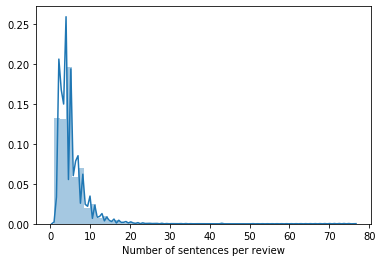

In [0]:
#Plot distribution of number of sentences per review
figdist = sns.distplot(graph_df_.text,axlabel="Number of sentences per review")
fig = figdist.get_figure()
#fig.savefig("/content/text_dist_.png")

In [0]:
#Check the concentration of number of sentences per review
print("Reviews composed by a number of sentences between 3 and 7 are",len(graph_df_[(graph_df_["text"]<8) & (graph_df_["text"]>2)])/len(graph_df_)*100,"% of the total.")

Reviews composed by a number of sentences between 3 and 7 are 64.07764077640776 % of the total.


In [0]:
#Check the upper bounds
print("The articles have at least",graph_df['text'].min(),"sentences and at most",graph_df['text'].max())
print("The summaries have at least",graph_df['summary'].min(),"sentences and at most",graph_df['summary'].max())

The articles have at least 1 sentences and at most 76
The summaries have at least 1 sentences and at most 11


In [0]:
#Analysis of number of words per text
text_lens = [len(word_tokenize(str(db['Text'][i]))) for i in range(len(db)-1)]
summary_lens = [(len(word_tokenize(str(db['Summary'][i])))) for i in range(len(db)-1)]
graph_df = pd.DataFrame()
graph_df['text'] = text_lens
graph_df['summary'] = summary_lens

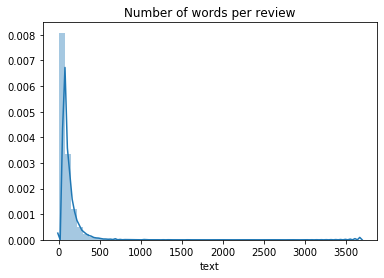

In [0]:
#Plot distribution of number of words per review
figdist = sns.distplot(graph_df.text).set_title('Number of words per review')
fig = figdist.get_figure()
#fig.savefig("/content/text_worddist.png")

Text(0.5, 1.0, 'Number of words per review')

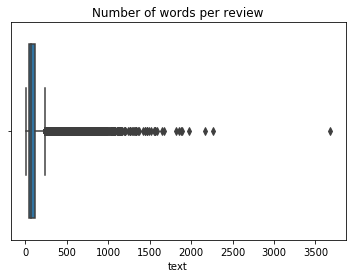

In [0]:
#Boxplot of number of words per review
sns.boxplot(graph_df.text).set_title('Number of words per review')

In [0]:
#Check concentration of number of words per review
print("Reviews composed by a number of words between 10 and 100 are",len(graph_df[(graph_df["text"]<100) & (graph_df["text"]>10)])/len(graph_df)*100,"% of the total.")

Reviews composed by a number of words between 10 and 100 are 68.13268132681327 % of the total.


In [0]:
print("Word count variance coefficient:",stdev(graph_df.text)/mean(graph_df.text))
print("Sentence count variance coefficient:",stdev(graph_df_.text)/mean(graph_df_.text))

Word count variance coefficient: 1.0229537446974803
Sentence count variance coefficient: 0.7352913772463048


##**Text Pre-processing**

In [0]:
#List of contractions to transform
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


#Function to transform the contraction in the extended form
def rem_contractions(x):
  x = str(x).split()
  new_text = []
  for word in x:
    if word in contractions:
      new_text.append(contractions[word])
    else:
      new_text.append(word)
  return ' '.join([str(elem) for elem in new_text])

#Function to apply preprocessing operations
def text_preprocessing(x,remove_stopwords=True):
  cleaned = rem_contractions(x)
  cleaned = re.sub(r"'s\b","", cleaned) #remove genitives
  cleaned = pd.Series(cleaned).str.replace("[^a-zA-Z]", " ") # remove punctuation, special characters and numbers
  cleaned = [s.lower() for s in cleaned] #to lowercase
  if remove_stopwords: 
    cleaned = " ".join([i for i in cleaned if i not in stop_words]) 
  #No stemming because it could cause a loss of information
  return cleaned

##**Methodologies**

###**1. Topic focused**

####**1.1 Latent Semantic Analysis**

In [0]:
def weighting(input,weight):
  #Preprocess the input
  sentences_cleaned = [text_preprocessing(y) for y in (sent_tokenize(input))]
  #Compute occurence of each word for each sentence
  DFs = []
  if weight == "f":
    for sent in sentences_cleaned:
      tokens = nltk.word_tokenize(sent)
      tokens2 = pd.DataFrame(tokens)
      tokens2.columns=['Frequency']
      tokens2 = pd.DataFrame(tokens2.Frequency.value_counts())
      tokens2 = tokens2.reset_index()
      tokens2.columns = ['Word','Frequency']
      DFs.append(tokens2)
      df = DFs[0]
      i=0
      for elem in DFs:
        df = pd.merge(df,elem,on="Word",how="outer")
      df.columns = [str(i) for i in range(len(df.columns))]
      df = df.drop('1',axis=1)
      df = df.replace(np.nan,0)
      df.set_index("0",inplace=True)
      df.columns = [str(i) for i in range(len(df.columns))]
      df = df.as_matrix()
    return df
  elif weight == "tf":
    for sent in sentences_cleaned:
      tokens = nltk.word_tokenize(sent)
      length = len(tokens)
      tokens2 = pd.DataFrame(tokens)
      tokens2.columns=['TF']
      tokens2 = pd.DataFrame(tokens2.TF.value_counts()/length)
      tokens2 = tokens2.reset_index()
      tokens2.columns = ['Word','TF']
      DFs.append(tokens2)
      df = DFs[0]
      i=0
      for elem in DFs:
        df = pd.merge(df,elem,on="Word",how="outer")
      df.columns = [str(i) for i in range(len(df.columns))]
      df = df.drop('1',axis=1)
      df = df.replace(np.nan,0)
      df.set_index("0",inplace=True)
      df.columns = [str(i) for i in range(len(df.columns))]
      df = df.as_matrix()
    return df
  elif weight == 'tf.idf':
    for sent in sentences_cleaned:
      tokens = nltk.word_tokenize(sent)
      length = len(tokens)
      tokens2 = pd.DataFrame(tokens)
      tokens2.columns=['TFIDF']
      tokens2 = pd.DataFrame(tokens2.TFIDF.value_counts()/length)
      tokens2 = tokens2.reset_index()
      tokens2.columns = ['Word','TFIDF']
      DFs.append(tokens2)
      df = DFs[0]
      i=0
      for elem in DFs:
        df = pd.merge(df,elem,on="Word",how="outer")
      df.columns = [str(i) for i in range(len(df.columns))]
      df = df.drop('1',axis=1)
      df = df.replace(np.nan,0)
      df.set_index("0",inplace=True)
      df.columns = [str(i) for i in range(len(df.columns))]
      num = len(df.columns)
      rows = []
      for index in df.index:
        den = np.count_nonzero(df.loc[index])
        idf = num/den
        idf = np.log(idf)
        row = df.loc[index]*idf
        rows.append(row)
    return pd.DataFrame(rows).as_matrix()

def SVD_weight(input,weight):
  df = weighting(input,weight)
  U, S, VT = np.linalg.svd(df, full_matrices=0)
  return pd.DataFrame(VT)

def ranking_sent(input,weight):
  matrix = SVD_weight(input,weight)
  score = {}
  for i in matrix.columns:
    score[i]=np.sqrt(np.sum(matrix[i]**2))
  return score

def LSA_summarize(input,num_of_sentences,weight="tf.idf"):
  ranking = ranking_sent(input,weight)
  sentences = sent_tokenize(input)
  if num_of_sentences > len(sentences):
    print("ERROR: There are only",len(sentences),"sentences in the text.")
  else:
    s = pd.DataFrame(pd.concat((pd.Series(sentences),pd.Series(ranking)),axis=1))
    s.columns = ['Sentence','Score']
    s = s.sort_values("Score",ascending = False)
    summary_sentences = [i for i in s['Sentence'][:num_of_sentences]]
    return ' '.join([str(elem) for elem in summary_sentences])


In [0]:
#Example with one review
summ = LSA_summarize(db['Text'][0],1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
#Example with one review
print("Review:","\n",db['Text'][0])
print()
print("Original summary:","\n",db['Summary'][0])
print()
print("Predicted summary:","\n",summ)

Review: 
 I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Original summary: 
 Good Quality Dog Food

Predicted summary: 
 The product looks more like a stew than a processed meat and it smells better.


###**2. Indicator Representation**

####**2.1 Graph based**

#####2.1.1 TextRank
[TextRank](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/) è un modello a grafo sviluppato per singolo documento, che costruisce un grafo ricreando un vertice per ogni frase e degli edge mediante una misura basata sul numero di parole in comune fra due frasi, normalizzato per la lunghezza delle frasi. TextRank usa score di similarità continui - probabilmente iterativi sulle parole in comune - come pesi per gli edge. Infine, TextRank che non considera alcuna feature addizionale. 

In order to represent the text, word embeddings will be used to create vectors for our sentences. We could have also used the Bag-of-Words or TF-IDF approaches to create features for our sentences, but these methods ignore the order of the words (and the number of features is usually pretty large). We will be using the pre-trained Wikipedia 2014 + Gigaword 5 GloVe vectors.

In [0]:
#Load GloVe for text representation
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2019-12-29 16:17:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-12-29 16:17:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-12-29 16:17:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [0]:
# Extract word vectors
word_embeddings = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

The dictionary `word_embeddings` will contains 400000 terms, each one represented by a vector of dimension (100,). Then, sentences vector representation will be obtained by computing the mean of all the vectors representing each word in the given sentence, gaining a consolidated vector for the sentence.
<br>
Thus the TextRank algorithm will be performed through the following phases:
1. split the text into sentences
2. apply preprocessing operation to them
  - transform contraction
  - remove punctuation, special characters and numbers
  - convert to lowercase
  - remove stop words
3. if the sentence exist, take the embedding of each word in the sentence, if present, otherwise returns a vector of zeros
4. compute the mean of the vector for each word in the sentence
5. compute the cosine similarity among all the sentences into a $nxn$ matrix
6. convert this matrix into a graph
7. uses `PageRank` algorithm to extract an importance score
8. rank sentences based on their score
9. select the best N sentences

In [0]:
#Function to get the summary
def summary(x,N,pretty=False):
  #Split into preprocessed and not preprocessed sentences
   sentences_cleaned = [text_preprocessing(y) for y in (sent_tokenize(x))]
   sentences = [y for y in (sent_tokenize(x))]
  #Text representation
   sentence_vectors = [] 
   for i in sentences_cleaned:
     if len(i) != 0:
       v = sum([word_embeddings.get(w, np.zeros((100,))) for w in i.split()])/(len(i.split())+0.001)
     else:
       v = np.zeros((100,))
     sentence_vectors.append(v) #IL PROBLEMA È QUI
   #Compute similarity matrix
   sim_mat = np.zeros([len(sentences), len(sentences)])
   for i in range(len(sentences)):
     for j in range(len(sentences)):
       if i != j:
         sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,100), sentence_vectors[j].reshape(1,100))[0,0]
   #Convert similarity matrix into a graph
   nx_graph = nx.from_numpy_array(sim_mat)
   scores = nx.pagerank(nx_graph)
   #Rank sentences
   ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
   #Select top N sentences
   summary=[]
   for i in range(N):
     summary.append(ranked_sentences[i][1])
   if pretty:
     return ' '.join([str(elem) for elem in summary]) #Return the readable text
   else:
     return summary #Return the list of summary sentences

In [0]:
#Example with one review
print("Review:","\n",db['Text'][2])
print()
print("Original summary:","\n",db['Summary'][2])
print()
print("Predicted summary:","\n",summary(db['Text'][2],1,pretty=True))

Review: 
 This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.

Original summary: 
 "Delight" says it all

Predicted summary: 
 And it is a tiny mouthful of heaven.


#####**2.1.2 Gensim (TextRank)**

[`Gensim`](https://radimrehurek.com/gensim/summarization/summariser.html) implements TextRank summarization

In [0]:
from gensim.summarization.summarizer import summarize
gensim_result = summarize(db['Text'][5])

In [0]:
#Example with one review
print("Review:","\n",db['Text'][5])
print()
print("Original summary:","\n",db['Summary'][5])
print()
print("Predicted summary:","\n",gensim_result)

Review: 
 I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat.

Original summary: 
 Nice Taffy

Predicted summary: 
 The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc.


#####**2.1.3 PytextRank (TextRank)**


[PyTextRank](https://github.com/DerwenAI/pytextrank/blob/master/example.py) is a Python implementation of TextRank as a spaCy extension, used to extract the top-ranked phrases from text documents, infer links from unstructured text into structured data and run extractive summarization of text documents.

In [0]:
!pip install pytextrank

In [0]:
import logging
import pytextrank
import spacy
import sys

In [0]:
#Load a spaCy model, depending on language, scale, etc.
nlp = spacy.load("en_core_web_sm")

#Add PyTextRank into the spaCy pipeline
tr = pytextrank.TextRank(logger=None)
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)

In [0]:
#Use the algoruithm
doc = nlp(db['Text'][101])
#print("pipeline", nlp.pipe_names)
#print("elapsed time: {} ms".format(tr.elapsed_time))


In [0]:
#Select the top N sentences
N=1
#Print results
print("Review:","\n",db['Text'][101])
print()
print("Original summary:","\n",db['Summary'][101])
print()
print("Predicted summary:")
pytextrank_result = []
for sent in doc._.textrank.summary(limit_phrases=15, limit_sentences=N):
    pytextrank_result.append(sent)
print(' '.join([str(elem) for elem in pytextrank_result]))

Review: 
 Arrived slightly thawed. My parents wouldn't accept it. However, the company was very helpful and issued a full refund.

Original summary: 
 Great Support

Predicted summary:
However, the company was very helpful and issued a full refund.


In [0]:
#Function for further analysis
def PTR(x,N=1):
  nlp = spacy.load("en_core_web_sm")
  tr = pytextrank.TextRank(logger=None)
  nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)
  doc = nlp(x)
  pytextrank_result = []
  for sent in doc._.textrank.summary(limit_phrases=15, limit_sentences=N):
    pytextrank_result.append(sent)
  return ' '.join([str(elem) for elem in pytextrank_result])

####**2.2 Feature based**

#####2.3.1 Luhn's Algorithm

[Luhn's Algorithm](http://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf) evaluates the “significance” of the word that is calculated from the frequency. Precisely, it:
1. Calculate signficant words in the text by means of a min and maximum ratio of occurence,ignoring most frequent words and least frequent ones 
2. For each sentence in the text calculate its weight based on the number of keywords squared divided by the windows size, which is the maximum distance between two significant words
3. Sort sentences in descending order based on their weight and output the first n of them.

In [0]:
#Function taking a word list and returning the set of keywords
def get_keywords(txt , min_ratio=0.05, max_ratio=0.5):
    txt = text_preprocessing(txt)
    length = len(nltk.word_tokenize(txt))
    count = {}    
    for word in nltk.word_tokenize(txt):
        count[word] = txt.count(word)
    keywords = []
    for word , cnt in count.items():
        percentage = count[word]*1.0 /length
        if percentage <= max_ratio and percentage >=min_ratio:
            keywords.append(word)
    #print("Found",100*len(keywords)/length,"% of keywords")
    return keywords

#Function returning the score of the sentence      
def get_sentence_weight (sentence , keywords):
    sen_list = nltk.word_tokenize(text_preprocessing(sentence))
    window_start = 0; window_end = -1;
    #Compute window start
    for i in range(len(sen_list)):
        if sen_list[i] in keywords:
            window_start = i
            break
    #Compute window end
    for i in range(len(sen_list) - 1 , 0 , -1) :
        if sen_list[i] in keywords:
            window_end = i
            break
    if window_start > window_end :
        return 0
    window_size = window_end - window_start + 1
    #Occurence of keywords in the sentence
    keywords_cnt = 0
    for w in sen_list :
        if w in keywords:
            keywords_cnt +=1
    #Return squared occurence of keywords normalized by window size
    score = keywords_cnt*keywords_cnt*1.0 / window_size
    return score

def Luhn_summarize(txt,num_of_sentences = 1):
  keywords_list = get_keywords(txt)
  score = {}
  for sentence in sent_tokenize(txt):
    score[sentence] = get_sentence_weight (sentence , keywords_list)
  #Convert the dictionary into DF
  Sentence = [i for i in score.keys()]
  Score = [i for i in score.values()]
  score = {'Sentence':Sentence,'Score':Score}
  score = pd.DataFrame(score)
  #Sort the DF
  ranking = score.sort_values("Score",ascending = False)
  summary_sentences = [i for i in ranking['Sentence'][:num_of_sentences]]
  return ' '.join([str(elem) for elem in summary_sentences])

In [0]:
#Example with one review
print("Review:","\n",db['Text'][99])
print()
print("Original summary:","\n",db['Summary'][99])
print()
print("Predicted summary:","\n",Luhn_summarize(db['Text'][99]))

Review: 
 I fed this to my Golden Retriever and he hated it.  He wouldn't eat it, and when he did, it gave him terrible diarrhea.  We will not be buying this again.  It's also super expensive.

Original summary: 
 Bad

Predicted summary: 
 He wouldn't eat it, and when he did, it gave him terrible diarrhea.


####**2.3 Deep Learning based**



#####2.3.1 **Extractive summarization** with BERT Summarizer

[BERT](https://arxiv.org/abs/1810.04805) , which stands for Bidirectional Encoder Representations from Transformers, is a pre-train deep bidirectional representations from unlabeled text, jointly conditioning on both left and right context in all layers. BERT model can be fine-tuned to create several state-of-art models for text mining tasks.\
In particular, as far as text summarization, a [Bert Extractive Summarizer](https://pypi.org/project/bert-extractive-summarizer/) has been already recently released by fine-tuning BERT architecture.

In [0]:
!pip install spacy==2.1.3
!pip install transformers==2.2.0
!pip install bert-extractive-summarizer

In [0]:
#Import Bert summarizer 
from summarizer import Summarizer

In [0]:
BERT = Summarizer()

In [0]:
def BERT_summarize(txt):
  result = BERT(txt)
  summary = ''.join(result)
  s = sent_tokenize(summary)
  return s[0]

In [0]:
#Example with one review
print("Review:","\n",db['Text'][10003])
print()
print("Original summary:","\n",db['Summary'][10003])
print()
print("Predicted summary:","\n",BERT_summarize(db['Text'][10003]))

Review: 
 My child was exclusively breastfed for 4 1/2 months and I gradually introduced Similac Organic formula to supplement (my breastmilk started to dry up).  She found this was so much easier to eat she gave up on me by 5 1/2 months.  By the time I completely stopped nursing she was so constipated from the formula that I switched.  She winced and cried and worked so long to just produced a hard ball the size of ping pong ball.  It was horrible!  I realized I was the one helping her poo with nursing and then she lost all ability when she went full-formula.  I say switch....

Original summary: 
 Horribly Constipating

Predicted summary: 
 My child was exclusively breastfed for 4 1/2 months and I gradually introduced Similac Organic formula to supplement (my breastmilk started to dry up).


#####2.3.2 **Abstractive summarization** with Sequence2Sequence LSTM model with Attention 

In [0]:
from keras import backend as K
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import warnings
from sklearn.model_selection import train_test_split

In [0]:
#Reduce dataset dimensions
db = db[['Text','Summary']]
db.columns = ['text','summary']

In [0]:
#Apply preprocessing operations to the texts
cleaned_text = []
for t in db['text']:
    cleaned_text.append(text_preprocessing(t))
db['text'] = cleaned_text
print("Text preprocessed.")

#Apply preprocessing operations to the summaries
cleaned_summary = []
for t in db['summary']:
    cleaned_summary.append(text_preprocessing(str(t)))
db['summary'] = cleaned_summary
db['summary'].replace('', np.nan, inplace=True)
print("Summary preprocessed.")

db.dropna(axis=0,inplace=True)
print("NA removed.")

Text preprocessed.
Summary preprocessed.
NA removed.


In [0]:
#Add "START-END" and "sostok-eostok"
db['summary'] = db['summary'].apply(lambda x : '_START_ '+ x + ' _END_')
db['summary'] = db['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [0]:
db.head(1)

,text,summary
0,bought several vitality canned dog food produc...,sostok _START_ good quality dog food _END_ eo...


Then, we divide the corpus into training and validation set:

In [0]:
x_tr,x_val,y_tr,y_val=train_test_split(np.array(db['text']),np.array(db['summary']),test_size=0.01,random_state=0,shuffle=True)

It is now necessary to perform a rare words analysis. In order to do so, training set articles will be tokenized:

In [0]:
#Use tokenizer
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [0]:
thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.50530707178853
Total Coverage of rare words: 1.2645901069194654


In [0]:
#set maximum length
max_text_len=200 #Changeable
max_summary_len= 20

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 20313


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [0]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 73.61888701517707
Total Coverage of rare words: 2.444467713875155


In [0]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 3912


In [0]:
#Remove summaris with only START and END

ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

it is finally possible to write the **Sequence-to-sequence Model**.

In [0]:
#Create Attention Block

import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore") 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 100)     2031300     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200, 300), ( 481200      embedding[0][0]                  
_____________________________________________________________________________________________

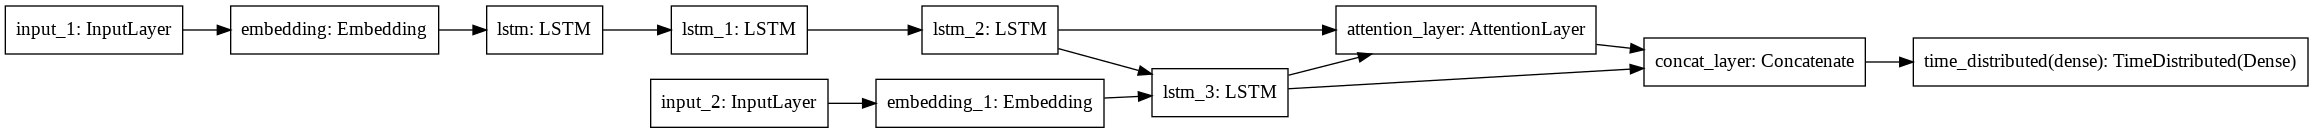

In [0]:
plot_model(model,to_file='/content/model.png',rankdir="LR")

In [0]:
#Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

#Set and early stopping criterion
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [0]:
#Train the model
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=30,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 98920 samples, validate on 1000 samples
Epoch 1/30
98920/98920 [==============================] - 826s 8ms/sample - loss: 1.3517 - val_loss: 1.1664
Epoch 2/30
98920/98920 [==============================] - 819s 8ms/sample - loss: 1.1557 - val_loss: 1.0881
Epoch 3/30
98920/98920 [==============================] - 819s 8ms/sample - loss: 1.0963 - val_loss: 1.0498
Epoch 4/30
98920/98920 [==============================] - 823s 8ms/sample - loss: 1.0602 - val_loss: 1.0243
Epoch 5/30
98920/98920 [==============================] - 804s 8ms/sample - loss: 1.0341 - val_loss: 1.0061
Epoch 6/30
98920/98920 [==============================] - 822s 8ms/sample - loss: 1.0146 - val_loss: 0.9957
Epoch 7/30
98920/98920 [==============================] - 821s 8ms/sample - loss: 0.9985 - val_loss: 0.9848
Epoch 8/30
98920/98920 [==============================] - 824s 8ms/sample - loss: 0.9849 - val_loss: 

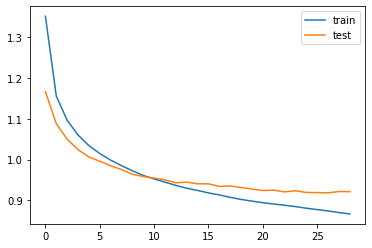

In [0]:
#Visualize the learning process
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [0]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

We are defining a function below which is the implementation of the inference process

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Finally, we can make inference to see the results:

In [0]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: looking pesto tastes good tuscany region favorite consistency bit runny moderate chunks garlic quite tasty 
Original summary: start bit pricey but yummy end 
Predicted summary:  start good stuff end


Review: biscuit obviously love taste dog food leave drop bowls gobble quickly fact would eat sick know quit food chef michael definitely created tasty meal thrilled ingredients first ingredient beef good much grain prefer meat less grain taste like said dogs cannot get enough think buy regular kibble definitely afternoon treat 
Original summary: start paws up end 
Predicted summary:  start my dog loves it end


Review: really like treat something hold dog licks rather taking chewy someplace getting busy ends looking holding long let keep lickin rollerball awesome friend dog old cannot chew 
Original summary: start awesome treat end 
Predicted summary:  start my dog loves these end


Review: couple cats part household always seem hungry underfoot kitchen feed twice day mostly dry p

##**Evaluation**


####**Human quality evaluation**

We will take 25 summaries made by each method and evaluate them with a score from 0 to 3 in terms of effectiveness and utility, namely the ability of reporting the main opinion expressed by the Amazon user about the given item. The score will be 
- **0**, if summary is completely non understandable
- **1**, if summary is clear but return other concepts or the opposite idea with respect to the original text
- **2**, if summary is well comprehensible and provide an information, but this information does not sum up effectively the content of the text
- **3**, if summary is perfectly comprehensible and provide the right information about the main content of the text
<br>
The final evaluation will be computed as the average score over the same reviews.

27 texts and summaries have been randomly selected from the dataset, in order to evaluate the performances of the summarizer:

In [0]:
dt = pd.read_csv("/content/test.csv")
dt = dt[['Text','Summary']]
dt

,Text,Summary
0,Mallomars Pure Chocolate Cookies are delicious...,Delicious!
1,"I can do organic, I usually prefer it. Whateve...",Taste terrible
2,This package of six boxes of forty eight bags ...,Misleading Advertisement
3,Biscuit and DJ obviously love the taste of thi...,2 Paws up!
4,Honestly I love cashews however these are a bi...,Good but could be better
5,"Only 5mg sodium per serving, chips are crisp. ...",Great chips with very low sodium
6,YES! Quaker went back to the old recipe! Woo...,The good ol' Classic Recipe that I grew up with
7,We go through a lot of this flavor. Love the ...,We Love It
8,I had this before and I will keep ordering it ...,Good spice mix
9,My chihuahua and pomeranian get so excited whe...,my dogs go crazy for Greenies


Thus, the 27 predicted summaries will be generated with each method, and written into different files, for human analysis:

In [0]:
##Extractive methods

#LSA
LSA = [LSA_summarize(dt['Text'][i],1) for i in range(27)]

#TextRank
TextRank = [summary(dt['Text'][i],1,pretty=True) for i in range(27)]

#Gensim TextRank
#TextRank_gensim = [summarize(dt['Text'][i]) for i in range(27)]

#PyTextRank
PyTextRank = [PTR(dt['Text'][i]) for i in range(27)]

#Luhn's Algorithm
Luhn = [Luhn_summarize(dt['Text'][i]) for i in range(27)]

#BERT NN
BERT = [BERT_summarize(dt['Text'][i]) for i in range(27)]

l = [LSA,TextRank,PyTextRank,Luhn,BERT]

In [0]:
#Create evaluation dataframe
ev = pd.DataFrame(pd.concat([pd.DataFrame([i for i in l])]))

In [0]:
#Add original text and summary:
ev = dt.transpose().append(ev)
ev

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Text,Mallomars Pure Chocolate Cookies are delicious...,"I can do organic, I usually prefer it. Whateve...",This package of six boxes of forty eight bags ...,Biscuit and DJ obviously love the taste of thi...,Honestly I love cashews however these are a bi...,"Only 5mg sodium per serving, chips are crisp. ...",YES! Quaker went back to the old recipe! Woo...,We go through a lot of this flavor. Love the ...,I had this before and I will keep ordering it ...,My chihuahua and pomeranian get so excited whe...,While I admit that the oversalted chip is addi...,I've bee subscribing to this coffee for months...,We've been buying Alpen for years as the close...,This product has 24g of protein per serving an...,This is my first order and it is MORE that I e...,My Solo Apricot Filling arrived this afternoon...,Since I joined Weight Watchers I have been try...,"This flavor is delicious!! I wish the ""Walkers...",Easy to prepare. Good cheesy flavor. Even I ca...,I've been eating this stuff here and there for...,"I will be buying this again, it is a great ta...",I absolutely LOVE Wish Pearls. They are an ex...,"Hey Bacon Lovers, The original BACONNAISE is a...",I have tried both the Tofu Shirataki and the N...,"This is the kind of garbage ""food"" that gives ...",The Coconut Palm Sugar wasn't too bad as a sub...,In the northeast it's pretty easy to find this...
Summary,Delicious!,Taste terrible,Misleading Advertisement,2 Paws up!,Good but could be better,Great chips with very low sodium,The good ol' Classic Recipe that I grew up with,We Love It,Good spice mix,my dogs go crazy for Greenies,burns the skin off your lips,Product has changed,Healthy AND Delicious cereal,Superb when you can't take whey or even when y...,Great!,Delighted,Weight Watcher heaven,Amazing!!,So easy a man age 63 can do it.,moldy!,"Great product, check expiration date",Wonderful Gift,Buy the ORIGINAL BACONNAISE not the LITE flavo...,So much better than the Non Tofu Shirataki!,Care about your health? Run away screaming!,Not bad as a substitute,Real Deal Beef Jerky
0,"Pour yourself an ice cold glass of milk, sit b...","I can do organic, I usually prefer it.",This package of six boxes of forty eight bags ...,In fact they would eat themselves sick!,I ate a 4th of the can then had to get somethi...,"Only 5mg sodium per serving, chips are crisp.",Woohoo!,Love the ability to use different flavors of c...,"Packaging was save as well, since it ships in ...",My chihuahua and pomeranian get so excited whe...,While I admit that the oversalted chip is addi...,It's weak and watery even on making a smaller ...,"Very low sodium (15 mg), 6 gr dietary fiber, 7...",The taste is fairly forgettable but not regret...,This is my first order and it is MORE that I e...,It's just as I remembered it from my childhood...,I love this stuff.........,This flavor is delicious!!,"More bulk, less calories per serving, except I...",I traded it in or another which was also moldy.,My issues were with the expiration date.,I absolutely LOVE Wish Pearls.,There is NOTHING else like it on store shelves!,I will certainly be back again.,"This is the kind of garbage ""food"" that gives ...",The Coconut Palm Sugar wasn't too bad as a sub...,In the northeast it's pretty easy to find this...
1,"Tasty chocolate on the inside, and an equally ...",I can't stand the taste of these I ended up ju...,There is nothing family sized about single use...,"But, as for the taste, like I said my dogs can...",I ate a 4th of the can then had to get somethi...,"Only 5mg sodium per serving, chips are crisp.","Sure, it's probably not as healthy for me as o...",We go through a lot of this flavor.,I will add (depending how spicy I want it) a t...,My chihuahua and pomeranian get so excited whe...,While I admit that the oversalted chip is addi...,Instead of it being strong and bold like dark ...,We eat about 6 boxes a month as we have it mos...,"Personally, a diet relatively 

The entries are substituted with each summary score:

In [0]:
ev = pd.read_csv("/content/score.csv")
ev.head()

,LSTM,LSA,TextRank,PyTextRank,Luhn,BERT
0,2,3,1,3,1.0,3
1,2,1,3,1,3.0,3
2,3,1,3,1,2.0,1
3,2,1,2,2,3.0,2
4,2,3,3,3,1.0,2


In [0]:
from statistics import mean, stdev
LTSM_av = mean(LSTM)
LTSM_sd = stdev(LSTM)

LSA_av = mean(LSA)
LSA_sd = stdev(LSA)

TextRank_av = mean(TextRank)
TextRank_sd = stdev(TextRank)

PyTextRank_av = mean(PyTextRank)
PyTextRank_sd = stdev(PyTextRank)

Luhn_av = mean(Luhn)
Luhn_sd = stdev(Luhn)

BERT_av = mean(BERT)
BERT_sd = stdev(BERT)

means = {"LSTM":LTSM_av,"LSA":LSA_av,"TR":TextRank_av,"PyTR":PyTextRank_av,"Luhn":Luhn_av,"BERT":BERT_av}
sds = {"LSTM":LTSM_sd,"LSA":LSA_sd,"TR":TextRank_sd,"PyTR":PyTextRank_sd,"Luhn":Luhn_sd,"BERT":BERT_sd}

In [0]:
res = pd.concat([pd.DataFrame(means.values(),index=means.keys(),columns=['Average']),pd.DataFrame(sds.values(),index=means.keys(),columns=['SD'])],axis=1).sort_values('Average',ascending=False)
res

,Average,SD
TR,2.407407,0.747265
LSA,2.259259,0.902671
LSTM,2.185185,0.921414
BERT,2.185185,0.833761
PyTR,1.925926,0.916764
Luhn,1.907407,0.855267


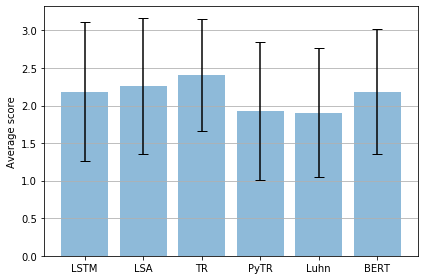

In [0]:
# First illustrate basic pyplot interface, using defaults where possible.
x = means.keys()
y = means.values()
fig, ax = plt.subplots()
ax.bar(x, y, yerr=sds.values(), align='center', alpha=0.5, ecolor='black', capsize=5)
ax.set_ylabel('Average score')
ax.yaxis.grid(True)
# Save the figure and show
plt.tight_layout()
plt.savefig('/content/results.png')
plt.show()

#**References**
- [Text Summarization Methods](https://github.com/icoxfog417/awesome-text-summarization#transfer-learning)
- [Text Summarization in Python](https://towardsdatascience.com/text-summarization-in-python-76c0a41f0dc4)
- [TextRank Algorithm](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/)
- [Gensim Summarizer](https://radimrehurek.com/gensim/summarization/summariser.html)
- [PyTextRank](https://github.com/DerwenAI/pytextrank/blob/master/example.py)
- [Luhn's Algorithm in Python](https://github.com/mohammadKhalifa/Luhn-s-summarizer)
- [Bert Extractive Summarizer](https://pypi.org/project/bert-extractive-summarizer/)
- [Abstractive Summarization with Keras](https://hackernoon.com/text-summarization-using-keras-models-366b002408d9)
- [Deep Learning for Text Summarization](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)
- [Evaluation measures for Text Summarization](https://www.researchgate.net/publication/220106310_Evaluation_Measures_for_Text_Summarization)